# Import Libraries and define functions


In [1]:
# Install libraries
!pip install unidecode
!pip install POT==0.4.0

# !pip install translators --upgrade
# !pip3 install sent2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec

--2023-05-26 18:48:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.38, 13.35.7.82, 13.35.7.50, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2594302560 (2.4G) [binary/octet-stream]
Saving to: ‘wiki.es.vec.2’

wiki.es.vec.2       100%[===================>]   2.42G  78.9MB/s    in 25s     

2023-05-26 18:48:57 (98.7 MB/s) - ‘wiki.es.vec.2’ saved [2594302560/2594302560]



In [3]:
# Import libraries
import pandas as pd
import requests

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

from unidecode import unidecode
import re, string

import nltk
nltk.download('stopwords')

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.keyedvectors import KeyedVectors

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [5]:
# Read Items (by Category) from Meli API
def read_items_api_to_df(cat_id, range_offset, ini_offset=0):

  # From API
  items_app = []
  df = pd.DataFrame()
  offset = ini_offset   
  for i in range(range_offset):  
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json()

    items_app = [*items_app, *items['results']]

    offset += 50

  # To df
  df = pd.json_normalize(items_app)[['id','title']]
  df.loc[:,'cat_id'] = cat_id

  # Merge cat name
  df = df.merge(df_cats, how='left', on='cat_id')

  return df

In [6]:
# Define words to remove (to avoid similarity related to this words)

# Spanish nltk stopwords
spanish_corpus_sw = nltk.corpus.stopwords.words('spanish')

# Relative to the delivery (or general to all products)
delivery_words = ['promo', 'promoción', 'listo', 'usado', 'original', 'nuevo', 'antiguo', 'oferta', 'entrega', 'envío',  'gratis', 
'inmediato', 'flete', 'off', 'precio', 'barato','art','ar','oficial']

# Colors 
color_words = ['negro', 'negra', 'azul', 'marrón', 'gris', 'verde', 'naranja', 'rosa', 'púrpura', 'rojo', 'roja', 'blanco', 'blanca',
               'amarillo','amarilla','turquesa', 'borgoña', 'lavanda', 'magenta', 'salmón', 'cian', 'beige', 'rosado','rosada', 'lila',  
               'fucsia', 'mostaza', 'ocre', 'trullo', 'malva', 'ciruela', 'melocotón', 'violeta', 'granate', 
               'color','colores','oscuro','oscura', 'claro','clara', 'pálido','pálida']

# Only 1 word (might be errors)
unique_letters = ['á','é','í','ó','ú','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'ñ', 'o', 
                  'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Stop words with unidecode as well since matching needs to be only with unidecoded values (to avoid random misspelling of words)
stopword = spanish_corpus_sw + delivery_words + color_words + unique_letters
uni_stopword = [unidecode(x) for x in stopword]

list_stopword = list(set(stopword+uni_stopword))

list_stopword.sort()
display(len(list_stopword),list_stopword[:10],list_stopword[-10:])

488

['a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'amarilla',
 'amarillo',
 'ante',
 'antes',
 'antiguo']

['yo', 'z', 'á', 'é', 'él', 'éramos', 'í', 'ñ', 'ó', 'ú']

In [7]:
# Load spanish word to vec (embedding)
wordvectors_file_vec = 'wiki.es.vec'  
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

# Words present in embedding
emb_words = wordvectors.key_to_index.keys()

# Functions

In [8]:
# Function to clean titles, and prepare for embeddings
def clean_titles(df, col, list_stopword, emb_words):

  # Remove spaces, turn to lower, remove special characters (keep accents), keep letters (not numbers) and spaces, remove extra spaces in between
  df[col+'_clean'] = df[col].str.strip().str.lower()
  df[col+'_clean'] = df[col+'_clean'].apply(lambda x: re.sub(r'[^A-Za-zÀ-ÿ ]+', '', x))
  df[col+'_clean'] = df[col+'_clean'].apply(lambda x: re.sub(' +',' ', x))
  
  # Split 
  df[col+'_clean_split'] = df[col+'_clean'].str.split()

  # Remove stop words (for tf-idf)
  df[col+'_clean_split'] = df[col+'_clean_split'].apply(lambda x: [word for word in x if word not in list_stopword])

  # Remove stop words (for tf-idf)
  df[col+'_clean_tfidf'] = df[col+'_clean_split'].apply(lambda x: [stemmer.stem(word) for word in x]).copy()

  # Keep only words in embedding (for embedding)
  df[col+'_clean_embedding'] = df[col+'_clean_split'].apply(lambda x: [word for word in x if word in emb_words]).copy()
  


  return df

## Tf-Idf + Cosine similarity

In [9]:
# Fuction to calculate tfidf vector representation of words in titles
def vector_titles_tfidf(df):

  # Get corpus from pre-processed Stemmed and join in a sentence
  corpus_tfidf = df.title_clean_tfidf.apply(lambda w: ' '.join(w))
  corpus_tfidf = corpus_tfidf.apply(unidecode)

  # Instantiate vectorizer and transform corpus - Remove words occuring low times
  vectorizer = TfidfVectorizer(min_df=1)
  X = vectorizer.fit_transform(corpus_tfidf)

  # Get tf idf for each row 
  df_tfidf = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out(), index=df.index)
  
  # Get idf, sort by idf value
  idf_words = pd.DataFrame.from_dict(vectorizer.vocabulary_, orient ='index').reset_index().rename(columns={'index':'emb_word'}).sort_values(0).set_index(0)
  idf_words.loc[:,'idf'] = vectorizer.idf_
  idf_words = idf_words.sort_values('idf', ascending=False)

  return df_tfidf, idf_words
  
  
# Fuction to calculate cosine similarity between titles
def calculate_cosine_similarity_tfidf(df_tfidf):
  df_A = df_tfidf.copy()
  df_B = df_tfidf.copy()
  df_cosine_tf = pd.DataFrame(index=df_A.index)
  A = df_A.values


  from numpy.linalg import norm
  i=0
  for item in df_B.index:
    # print(i)
    B = df_B.loc[item].values
    cosine = np.dot(A,B)/(norm(A,axis=1)*norm(B))
    df_cosine_tf.loc[:,item] = cosine
    i+=1

  return df_cosine_tf

## Embeddings + Cosine similarity

In [10]:
# Function to get embedding for each title
def vector_titles(df, col):

  # Get embeddings for all words and sum vectors
  df.loc[:,col+'_sum_vector'] = df.loc[:,col+'_clean_embedding'].apply(lambda t: sum([wordvectors.get_vector(w, norm=False) for w in t]))

  return df

In [11]:
# Fuction to calculate cosine similarity between titles
def calculate_cosine_similarity(df):

  # Get title norm
  df.loc[:,'title_norm'] = df['title_sum_vector'].apply(norm)

  df_cosine = pd.DataFrame(index=df.index)
  i=0
  for item in df.index:
    # print(i)

    # Formula for cosine similarity: cosine = np.dot(A,B)/(norm(A,axis=1)*norm(B))
    np_dot = df['title_sum_vector'].apply(lambda x: np.dot( x , df.loc[item,'title_sum_vector']) )  
    cosine = np_dot.div(df.title_norm.values * df.title_norm[item] )
    df_cosine.loc[:,item] = cosine

    i+=1

  return df, df_cosine

## View most similar N products
- In general
- In same category
- In alternative category 1
- In alternative category 2

In [38]:
def show_any_similar_and_by_category(df_plus_c, check_id, col,
                                     main_cat, exp_cat1, exp_cat2,
                                     q_any_cat, q_main_cat, q_exp_cat1, q_exp_cat2,
                                     ):
  
  title_name = df_plus_c.loc[ check_id , 'title' ]

  display(f'################################ { check_id } - { title_name } ################################',
          '~',
          f'Set of most similar {q_any_cat} articles in ANY category:',
          df_plus_c[['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_any_cat),

          f'Set of most similar {q_main_cat} articles in main category {main_cat}:',
          df_plus_c.loc[df_plus_c.cat_name==main_cat,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_main_cat),
          
          f'Set of most similar {q_exp_cat1} articles in specific explore category {exp_cat1}:',
          df_plus_c.loc[df_plus_c.cat_name==exp_cat1,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_exp_cat1),
          
          f'Set of most similar {q_exp_cat2} articles in specific explore category {exp_cat2}:',
          df_plus_c.loc[df_plus_c.cat_name==exp_cat2,['cat_name','title', col,check_id]].sort_values(check_id,ascending=False).head(q_exp_cat2),
          '~',
          '################################################################################################################################',
          
          )

## Plot results for business Story Telling

### PCA Principal components analysis (with embedding)

In [13]:
## PCA Principal components analysis of Embedding vectors
def pca_calculation(df):

  # Expand list into columns to do pca and clusterize
  df_cluster = pd.DataFrame(df['title_sum_vector'].to_list(), index=df.index)
  # df_cluster.head(2)

  # Define transform
  pca = PCA(n_components=20)
  # Prepare transform on dataset
  pca.fit(df_cluster)
  # apply transform to dataset
  df_cluster_pca = pca.transform(df_cluster)

  # Explained variance ratio --> 2 is more than enough
  print(f'Sum of explained variance {pca.explained_variance_ratio_.sum()} \nlist by variable {pca.explained_variance_ratio_}')

  return df_cluster_pca

### KMeans clustering (of pca components)

In [14]:
## KMeans clustering
def kmeans_clustering_elbow(df_cluster_pca, k_max=10):

  # Running K-Means with a range of k
  distortions = []
  K = range(1,k_max)
  for k in K:
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(df_cluster_pca)
      distortions.append(kmeanModel.inertia_)

  # Plotting the distortions of K-Means
  plt.figure(figsize=(5,2))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()


def kmeans_clustering_modelling(df_cluster_pca, k_selected=4):

  # Kmeans with defined number of clusters
  kmeans = KMeans(n_clusters=k_selected, random_state=0, n_init="auto").fit(df_cluster_pca)
  cluster_pred = kmeans.predict(df_cluster_pca)
  
  return kmeans, cluster_pred

### TSNE representation (of pca components)

In [15]:
## TSNE representation of PCA vectors 
def get_tsne_pc(df_cluster_pca, df):

  # Create a dataframe of pca scores
  df_pc = pd.DataFrame(df_cluster_pca, index=df.index)

  # Perform t-SNE on PCs scores
  tsne_em = TSNE(n_components = 2, perplexity = 30.0, early_exaggeration = 12, 
                n_iter = 1000, learning_rate = 368, random_state=0, verbose = 1).fit_transform(df_pc)
               
  # Add calculated tsne columns
  df_pc[['tsne1','tsne2']] = tsne_em

  # Add other important data
  df_pc_plot = df_pc[['tsne1','tsne2']].merge(df[['cat_name','title_clean_embedding','kmeans_cluster']], left_index=True, right_index=True)

  return df_pc_plot

## Plot titles in 2D TSNE plot
- labels 2 first words of embedding 
- colors (kmeans, categories or plain blue)

In [87]:
def plot_clusters_vectors(df_pc_plot,print_labels='no',colors='kmeans'):
  # Plot results (All)
  df_mini_plot = df_pc_plot

  x=df_mini_plot.tsne1
  y=df_mini_plot.tsne2
  labels=df_mini_plot.title_clean_embedding.apply(lambda x: ' '.join(x[0:2]))

  if colors=='kmeans':
    # Kmeans colors
    dict_colors_kmeans = {0:'#713e5a', 1:'#63a375', 2:'#edc79b', 3:'#d57a66', 4: '#ca6680', 
                          5:'#395B50', 6:'#92AFD7', 7:'#b0413e', 8:'#4381c1'
                          #'#736ced', '#631a86', '#de541e', '#022b3a', '#000000'
               }
    colors=df_mini_plot.kmeans_cluster.replace(dict_colors_kmeans)

  elif colors=='cat':
    # Category colors
    cat_list = list(df_mini_plot.cat_name.unique())
    cat_list.sort()
    dict_colors_cat = {cat_list[0]:'#713e5a', cat_list[1]:'#63a375', cat_list[2]:'#edc79b'}
    colors=df_mini_plot.cat_name.replace(dict_colors_cat)

  else: 
    colors='blue'

  
  plt.scatter(x=x, y=y, c=colors)
  # Loop for annotation of all points (if small quantity)
  if print_labels=='yes':
    for i in range(len(x)):
        plt.annotate(labels[i], (x[i], y[i] + 0.2))
  plt.show()

## Imput Data and Pre-Processing

In [100]:
# Categories 
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')
json_cats = cats.json()
df_cats = pd.DataFrame(json_cats).rename(columns={'id':'cat_id','name':'cat_name'})
df_cats.head()

,cat_id,cat_name
0,MLA5725,Accesorios para Vehículos
1,MLA1512,Agro
2,MLA1403,Alimentos y Bebidas
3,MLA1071,Animales y Mascotas
4,MLA1367,Antigüedades y Colecciones


In [101]:
# Read data from a main category ('Ropa y Accesorios') to find similar products inside de category
# and 2 other categories to explore ('Deportes y Fitness', 'Joyas y Relojes') to find similar products inside other categories

# Read data from meli API
df1 = read_items_api_to_df(cat_id='MLA1430', ini_offset=0, range_offset=20)  # Ropa y Accesorios     (main category to analysis)
df2 = read_items_api_to_df(cat_id='MLA1276', ini_offset=0, range_offset=20)  # Deportes y Fitness    (extra category to explore)
df3 = read_items_api_to_df(cat_id='MLA3937', ini_offset=0, range_offset=20)  # Joyas y Relojes       (extra category to explore)
df = pd.concat([df1,df2,df3], axis=0)
display(df.shape, df.head(2), df.cat_name.value_counts())

# Drop duplicates ('id')
df = df.drop_duplicates(subset='id')

# Set index id
df = df.set_index('id')

# Clean titles
df = clean_titles(df=df, col='title', list_stopword=list_stopword, emb_words=emb_words)
# display(df.head(2))

display(df.shape, df.head(2))

(2999, 4)

,id,title,cat_id,cat_name
0,MLA1248731911,Valija Chica Carry On Maleta De Viaje Peso Plu...,MLA1430,Ropa y Accesorios
1,MLA748387571,Campera Inflable De Mujer Con Polar. Brocatto,MLA1430,Ropa y Accesorios


Ropa y Accesorios     1000
Deportes y Fitness    1000
Joyas y Relojes        999
Name: cat_name, dtype: int64

(2931, 7)

,title,cat_id,cat_name,title_clean,title_clean_split,title_clean_tfidf,title_clean_embedding
id,,,,,,,
MLA1248731911,Valija Chica Carry On Maleta De Viaje Peso Plu...,MLA1430,Ropa y Accesorios,valija chica carry on maleta de viaje peso plu...,"[valija, chica, carry, on, maleta, viaje, peso...","[valij, chic, carry, on, malet, viaj, pes, plu...","[valija, chica, carry, on, maleta, viaje, peso..."
MLA748387571,Campera Inflable De Mujer Con Polar. Brocatto,MLA1430,Ropa y Accesorios,campera inflable de mujer con polar brocatto,"[campera, inflable, mujer, polar, brocatto]","[camper, inflabl, muj, pol, brocatt]","[campera, inflable, mujer, polar]"


## Tf-Idf and Cosine similarity

In [102]:
# Get vector for titles (sum of vector for individual words)
df_tfidf, idf_words = vector_titles_tfidf(df=df)

# Calculate cosine similarity for tfidf vectors
df_cosine_tf = calculate_cosine_similarity_tfidf(df_tfidf=df_tfidf)

# Add cosine similarity to df (category, title, title of tfidf)
df_plus_cosine_tfidf = df[['cat_name','title','title_clean_tfidf']].merge(df_cosine_tf, left_index=True,right_index=True)

display(df_tfidf.head(2), df_cosine_tf.head(2), df_plus_cosine_tfidf.head(2))

,ab,abbott,abdominal,abecedari,abism,abrazader,abre,abridor,abrig,abroj,...,zircon,zirconi,zld,zma,zodiac,zon,zoom,zoquet,zorb,zuec
id,,,,,,,,,,,,,,,,,,,,,
MLA1248731911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MLA748387571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,MLA1248731911,MLA748387571,MLA1152304087,MLA813975910,MLA883194883,MLA852472619,MLA1207103960,MLA1146886165,MLA814526447,MLA619208970,...,MLA1127890110,MLA871402717,MLA1315203707,MLA918537262,MLA867398957,MLA899158876,MLA1150039393,MLA1103784893,MLA1363794429,MLA872490100
id,,,,,,,,,,,,,,,,,,,,,
MLA1248731911,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.179412,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MLA748387571,0.0,1.0,0.0,0.099613,0.0,0.298927,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,cat_name,title,title_clean_tfidf,MLA1248731911,MLA748387571,MLA1152304087,MLA813975910,MLA883194883,MLA852472619,MLA1207103960,...,MLA1127890110,MLA871402717,MLA1315203707,MLA918537262,MLA867398957,MLA899158876,MLA1150039393,MLA1103784893,MLA1363794429,MLA872490100
id,,,,,,,,,,,,,,,,,,,,,
MLA1248731911,Ropa y Accesorios,Valija Chica Carry On Maleta De Viaje Peso Plu...,"[valij, chic, carry, on, malet, viaj, pes, plu...",1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MLA748387571,Ropa y Accesorios,Campera Inflable De Mujer Con Polar. Brocatto,"[camper, inflabl, muj, pol, brocatt]",0.0,1.0,0.0,0.099613,0.0,0.298927,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
examples = ['MLA800264201','MLA1345897001','MLA1150541880','MLA1379543968']

In [104]:
for id_e in examples:

  show_any_similar_and_by_category(df_plus_c=df_plus_cosine_tfidf, 
                                   col = 'title_clean_tfidf',
                                   check_id = id_e, q_any_cat=5,
                                   main_cat='Ropa y Accesorios', q_main_cat=5, 
                                   exp_cat1='Deportes y Fitness', q_exp_cat1=3, 
                                   exp_cat2='Joyas y Relojes', q_exp_cat2=3)

'################################ MLA800264201 - Zapatillas Jaguar Oficial Deportiva Art. # 918 Urbana Unisex ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_tfidf,MLA800264201
id,,,,
MLA800264201,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. # 918...,"[zapatill, jagu, deport, urban, unisex]",1.000000
MLA1128168428,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art #709 3...,"[zapatill, jagu, deport]",0.733531
MLA1199944724,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #925 ...,"[zapatill, jagu, deport]",0.733531
MLA1161335219,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9319...,"[zapatill, jagu, deport]",0.733531
MLA824312287,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9033...,"[zapatill, jagu, deport]",0.733531


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_tfidf,MLA800264201
id,,,,
MLA800264201,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. # 918...,"[zapatill, jagu, deport, urban, unisex]",1.000000
MLA1161335219,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9319...,"[zapatill, jagu, deport]",0.733531
MLA1128168428,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art #709 3...,"[zapatill, jagu, deport]",0.733531
MLA824312287,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9033...,"[zapatill, jagu, deport]",0.733531
MLA1199944724,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #925 ...,"[zapatill, jagu, deport]",0.733531


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_tfidf,MLA800264201
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatill, muj, urban, mod, cazzu]",0.300182
MLA810493610,Deportes y Fitness,Pack 10 Pecheras Fluo Deportivas Futbol Niños ...,"[pack, pecher, flu, deport, futbol, niñ, años,...",0.239805
MLA815779987,Deportes y Fitness,Pizarra Tactica Imantada Deportiva Imanes Nume...,"[pizarr, tactic, imant, deport, iman, numer, d...",0.190298


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_tfidf,MLA800264201
id,,,,
MLA1131576027,Joyas y Relojes,Reloj Táctico Ns Sumergible Unisex Deportivo D...,"[reloj, tactic, ns, sumerg, unisex, deport, di...",0.288984
MLA829139684,Joyas y Relojes,Reloj Pulsera Led Silicona Unisex Deportivo Aj...,"[reloj, pulser, led, silicon, unisex, deport, ...",0.279711
MLA1145502664,Joyas y Relojes,Reloj Led Touch Pulsera Silicona Unisex Deport...,"[reloj, led, touch, pulser, silicon, unisex, d...",0.279711


'~'

'################################################################################################################################'

'################################ MLA1345897001 - Borcegos Botita Acordonadas De Nena Niña Comodas Bajas Moda ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_tfidf,MLA1345897001
id,,,,
MLA1345897001,Ropa y Accesorios,Borcegos Botita Acordonadas De Nena Niña Comod...,"[borceg, botit, acordon, nen, niñ, comod, baj,...",1.000000
MLA917050544,Ropa y Accesorios,Zapatillas Botitas Borcego Zapato Corderito Be...,"[zapatill, botit, borceg, zapat, corderit, beb...",0.464345
MLA1364679263,Ropa y Accesorios,Borcegos De Nenas Niñas Con Tobillera Cordones...,"[borceg, nen, niñ, tobiller, cordon, mod]",0.454377
MLA1127541470,Ropa y Accesorios,Borcegos Acordonados Negros Bajos Con Base Tip...,"[borceg, acordon, negr, baj, bas, tip, marteens]",0.451466
MLA1134977262,Ropa y Accesorios,Zapatilla Niños Niñas Nena Nene Bebe 20 Al 34 ...,"[zapatill, niñ, niñ, nen, nen, beb, elastiz]",0.344863


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_tfidf,MLA1345897001
id,,,,
MLA1345897001,Ropa y Accesorios,Borcegos Botita Acordonadas De Nena Niña Comod...,"[borceg, botit, acordon, nen, niñ, comod, baj,...",1.000000
MLA917050544,Ropa y Accesorios,Zapatillas Botitas Borcego Zapato Corderito Be...,"[zapatill, botit, borceg, zapat, corderit, beb...",0.464345
MLA1364679263,Ropa y Accesorios,Borcegos De Nenas Niñas Con Tobillera Cordones...,"[borceg, nen, niñ, tobiller, cordon, mod]",0.454377
MLA1127541470,Ropa y Accesorios,Borcegos Acordonados Negros Bajos Con Base Tip...,"[borceg, acordon, negr, baj, bas, tip, marteens]",0.451466
MLA1134977262,Ropa y Accesorios,Zapatilla Niños Niñas Nena Nene Bebe 20 Al 34 ...,"[zapatill, niñ, niñ, nen, nen, beb, elastiz]",0.344863


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_tfidf,MLA1345897001
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatill, muj, urban, mod, cazzu]",0.136519
MLA1161597050,Deportes y Fitness,300 Lumens Luz Delantera Blanca Bici Usb Recar...,"[lumens, luz, delanter, bici, usb, recarg, mod]",0.104738
MLA1107839663,Deportes y Fitness,Bolsa De Dormir Peluche Para Niños.,"[bols, dorm, peluch, niñ]",0.097707


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_tfidf,MLA1345897001
id,,,,
MLA906160304,Joyas y Relojes,"Reloj Pulsera + Billetera Para Niños Y Niñas, ...","[reloj, pulser, billeter, niñ, niñ]",0.173845
MLA1213948758,Joyas y Relojes,Reloj Pulsera Infantil Digital Silicona Para N...,"[reloj, pulser, infantil, digital, silicon, ni...",0.168863
MLA1361367593,Joyas y Relojes,Reloj Infantil Con Luces Niños/ Niñas Malla Si...,"[reloj, infantil, luc, niñ, niñ, mall, silicon]",0.156842


'~'

'################################################################################################################################'

'################################ MLA1150541880 - 3 Corpiños Deportivos De Dama Mujer Algodón Peinado 85 A 105 ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_tfidf,MLA1150541880
id,,,,
MLA1150541880,Ropa y Accesorios,3 Corpiños Deportivos De Dama Mujer Algodón Pe...,"[corpiñ, deport, dam, muj, algodon, pein]",1.000000
MLA1103843903,Ropa y Accesorios,Top Corpiño Cocot Deportivo Algodón Y Lycra Ar...,"[top, corpiñ, cocot, deport, algodon, lycra]",0.397873
MLA619208970,Ropa y Accesorios,Remera Lisa Algodón Jersey Peinado Premium,"[remer, lis, algodon, jersey, pein, premium]",0.391654
MLA898319997,Ropa y Accesorios,Remera Lisa 100% Algodón Peinado Premium-excel...,"[remer, lis, algodon, pein, premiumexcelent, c...",0.378791
MLA930080199,Ropa y Accesorios,Pack 3 Corpiño Algodón Talles Especiales,"[pack, corpiñ, algodon, tall, especial]",0.363607


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_tfidf,MLA1150541880
id,,,,
MLA1150541880,Ropa y Accesorios,3 Corpiños Deportivos De Dama Mujer Algodón Pe...,"[corpiñ, deport, dam, muj, algodon, pein]",1.000000
MLA1103843903,Ropa y Accesorios,Top Corpiño Cocot Deportivo Algodón Y Lycra Ar...,"[top, corpiñ, cocot, deport, algodon, lycra]",0.397873
MLA619208970,Ropa y Accesorios,Remera Lisa Algodón Jersey Peinado Premium,"[remer, lis, algodon, jersey, pein, premium]",0.391654
MLA898319997,Ropa y Accesorios,Remera Lisa 100% Algodón Peinado Premium-excel...,"[remer, lis, algodon, pein, premiumexcelent, c...",0.378791
MLA930080199,Ropa y Accesorios,Pack 3 Corpiño Algodón Talles Especiales,"[pack, corpiñ, algodon, tall, especial]",0.363607


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_tfidf,MLA1150541880
id,,,,
MLA815779987,Deportes y Fitness,Pizarra Tactica Imantada Deportiva Imanes Nume...,"[pizarr, tactic, imant, deport, iman, numer, d...",0.150113
MLA1159062919,Deportes y Fitness,Media Antideslizante + Pantorrillera Sox® Depo...,"[medi, antidesliz, pantorriller, sox, deport]",0.104339
MLA1146144908,Deportes y Fitness,Medias Antideslizantes - Deportivas 3/4 Foxsoc...,"[medi, antidesliz, deport, foxsocks, premium]",0.101691


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_tfidf,MLA1150541880
id,,,,
MLA869158435,Joyas y Relojes,Argollas Oro 18k Y Plata 925 Torneada 29 Mm Mu...,"[argoll, oro, plat, torn, mm, muj, dam]",0.223205
MLA1137718010,Joyas y Relojes,Reloj Prune Dama Sumergible Garantía Oficial !.,"[reloj, prun, dam, sumerg, garant]",0.182194
MLA1148867662,Joyas y Relojes,Reloj De Dama Prune Malla Cuero Colores Garant...,"[reloj, dam, prun, mall, cuer, garant]",0.175108


'~'

'################################################################################################################################'

'################################ MLA1379543968 - Zapatillas De Mujer Livianas Comodas Moda Nadin ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_tfidf,MLA1379543968
id,,,,
MLA1379543968,Ropa y Accesorios,Zapatillas De Mujer Livianas Comodas Moda Nadin,"[zapatill, muj, livian, comod, mod, nadin]",1.000000
MLA1363582365,Ropa y Accesorios,Zapatillas Mujer Base Comoda Liviana Diseño Liz,"[zapatill, muj, bas, comod, livian, diseñ, liz]",0.453024
MLA1396602548,Ropa y Accesorios,Zapatillas Mujer Base Comoda Livianas Diseño M...,"[zapatill, muj, bas, comod, livian, diseñ, mer...",0.453024
MLA883351057,Ropa y Accesorios,Zapatilla Deportiva Mujer Liviana Air 1471,"[zapatill, deport, muj, livian, air]",0.370892
MLA905820014,Ropa y Accesorios,Zapatillas Urbanas Deportivas Elastizadas De M...,"[zapatill, urban, deport, elastiz, muj, livian]",0.363634


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_tfidf,MLA1379543968
id,,,,
MLA1379543968,Ropa y Accesorios,Zapatillas De Mujer Livianas Comodas Moda Nadin,"[zapatill, muj, livian, comod, mod, nadin]",1.000000
MLA1363582365,Ropa y Accesorios,Zapatillas Mujer Base Comoda Liviana Diseño Liz,"[zapatill, muj, bas, comod, livian, diseñ, liz]",0.453024
MLA1396602548,Ropa y Accesorios,Zapatillas Mujer Base Comoda Livianas Diseño M...,"[zapatill, muj, bas, comod, livian, diseñ, mer...",0.453024
MLA883351057,Ropa y Accesorios,Zapatilla Deportiva Mujer Liviana Air 1471,"[zapatill, deport, muj, livian, air]",0.370892
MLA905820014,Ropa y Accesorios,Zapatillas Urbanas Deportivas Elastizadas De M...,"[zapatill, urban, deport, elastiz, muj, livian]",0.363634


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_tfidf,MLA1379543968
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatill, muj, urban, mod, cazzu]",0.320202
MLA1161597050,Deportes y Fitness,300 Lumens Luz Delantera Blanca Bici Usb Recar...,"[lumens, luz, delanter, bici, usb, recarg, mod]",0.134073
MLA610683302,Deportes y Fitness,Inflador Mano Bicicleta Beto Cmpb-03b Doble Ac...,"[inflador, man, biciclet, bet, cmpbb, dobl, ac...",0.121652


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_tfidf,MLA1379543968
id,,,,
MLA933496061,Joyas y Relojes,Pulsera De Hombre Acero Negro Quirurgico Braza...,"[pulser, hombr, acer, quirurg, brazalet, mod]",0.192174
MLA902577559,Joyas y Relojes,Smart Watch Mujer Dt66 Moda Deportes Elegante ...,"[smart, watch, muj, dt, mod, deport, eleg, and...",0.177468
MLA1141285398,Joyas y Relojes,Reloj Xiaomi Mi Band 7 Smartwatch Oximetro 120...,"[reloj, xiaomi, band, smartwatch, oximetr, mod...",0.150138


'~'

'################################################################################################################################'

## Word Embeddings and Cosine similarity

In [105]:
# Get vector for titles (sum of vector for individual words)
df = vector_titles(df=df, col='title')
# display(df.head(2))

# Remove cases with no words in embedding
df = df[df.title_clean_embedding.str.len()!=0]
# display(df.head(2))

# Calculate cosine similarity matrix
df, df_cosine = calculate_cosine_similarity(df=df)

# Add cosine similarity to df (category, title, title of embedding)
df_plus_cosine = df[['cat_name','title','title_clean_embedding']].merge(df_cosine, left_index=True,right_index=True)

display(df.shape, df.head(2),df_cosine.head(2))

(2924, 9)

,title,cat_id,cat_name,title_clean,title_clean_split,title_clean_tfidf,title_clean_embedding,title_sum_vector,title_norm
id,,,,,,,,,
MLA1248731911,Valija Chica Carry On Maleta De Viaje Peso Plu...,MLA1430,Ropa y Accesorios,valija chica carry on maleta de viaje peso plu...,"[valija, chica, carry, on, maleta, viaje, peso...","[valij, chic, carry, on, malet, viaj, pes, plu...","[valija, chica, carry, on, maleta, viaje, peso...","[-3.319769, -0.5133859, -1.366031, -0.282705, ...",22.527727
MLA748387571,Campera Inflable De Mujer Con Polar. Brocatto,MLA1430,Ropa y Accesorios,campera inflable de mujer con polar brocatto,"[campera, inflable, mujer, polar, brocatto]","[camper, inflabl, muj, pol, brocatt]","[campera, inflable, mujer, polar]","[-0.528535, -0.36554718, -0.52331007, -0.32952...",11.684566


,MLA1248731911,MLA748387571,MLA1152304087,MLA813975910,MLA883194883,MLA852472619,MLA1207103960,MLA1146886165,MLA814526447,MLA619208970,...,MLA1127890110,MLA871402717,MLA1315203707,MLA918537262,MLA867398957,MLA899158876,MLA1150039393,MLA1103784893,MLA1363794429,MLA872490100
id,,,,,,,,,,,,,,,,,,,,,
MLA1248731911,1.000000,0.612462,0.625290,0.631915,0.585984,0.602994,0.661652,0.578803,0.660096,0.631098,...,0.584256,0.544279,0.522059,0.579662,0.547261,0.442911,0.578251,0.576718,0.553794,0.528934
MLA748387571,0.612462,1.000000,0.587302,0.642509,0.487553,0.758053,0.590993,0.577367,0.501043,0.571940,...,0.558883,0.461672,0.412464,0.552133,0.559028,0.393194,0.543891,0.510996,0.453420,0.517608


In [106]:
for id_e in examples:

  show_any_similar_and_by_category(df_plus_c=df_plus_cosine, 
                                   col = 'title_clean_embedding',
                                   check_id = id_e, q_any_cat=5,
                                   main_cat='Ropa y Accesorios', q_main_cat=5, 
                                   exp_cat1='Deportes y Fitness', q_exp_cat1=3, 
                                   exp_cat2='Joyas y Relojes', q_exp_cat2=3)

'################################ MLA800264201 - Zapatillas Jaguar Oficial Deportiva Art. # 918 Urbana Unisex ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA800264201
id,,,,
MLA800264201,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. # 918...,"[zapatillas, jaguar, deportiva, urbana]",1.000000
MLA1319984979,Ropa y Accesorios,Zapatillas Jaguar Deportiva Art. 9330 36 Al 40...,"[zapatillas, jaguar, deportiva]",0.935846
MLA1161335219,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9319...,"[zapatillas, jaguar, deportiva]",0.935846
MLA1128168428,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art #709 3...,"[zapatillas, jaguar, deportiva]",0.935846
MLA824312287,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9033...,"[zapatillas, jaguar, deportiva]",0.935846


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA800264201
id,,,,
MLA800264201,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. # 918...,"[zapatillas, jaguar, deportiva, urbana]",1.000000
MLA824312287,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9033...,"[zapatillas, jaguar, deportiva]",0.935846
MLA1161335219,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #9319...,"[zapatillas, jaguar, deportiva]",0.935846
MLA1319984979,Ropa y Accesorios,Zapatillas Jaguar Deportiva Art. 9330 36 Al 40...,"[zapatillas, jaguar, deportiva]",0.935846
MLA1199944724,Ropa y Accesorios,Zapatillas Jaguar Oficial Deportiva Art. #925 ...,"[zapatillas, jaguar, deportiva]",0.935846


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA800264201
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.705994
MLA1141229900,Deportes y Fitness,Zapatilla Calzado Trekking Reforzado Con Punte...,"[zapatilla, calzado, trekking, reforzado]",0.656608
MLA815779987,Deportes y Fitness,Pizarra Tactica Imantada Deportiva Imanes Nume...,"[pizarra, tactica, deportiva, imanes, deportes]",0.644568


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA800264201
id,,,,
MLA770743043,Joyas y Relojes,Malla Goma Silicona Deportiva Para Garmin Fore...,"[malla, goma, silicona, deportiva, garmin, for...",0.668053
MLA1109022657,Joyas y Relojes,Malla Silicona Deportiva Xiaomi Mi Band 5/6 - ...,"[malla, silicona, deportiva, band]",0.666144
MLA1327735473,Joyas y Relojes,Malla Xiaomi Mi Band 3 4 5 6 Y 7 Nylon Correa ...,"[malla, band, nylon, correa, deportiva]",0.657338


'~'

'################################################################################################################################'

'################################ MLA1345897001 - Borcegos Botita Acordonadas De Nena Niña Comodas Bajas Moda ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1345897001
id,,,,
MLA1345897001,Ropa y Accesorios,Borcegos Botita Acordonadas De Nena Niña Comod...,"[nena, niña, bajas, moda]",1.000000
MLA1134977262,Ropa y Accesorios,Zapatilla Niños Niñas Nena Nene Bebe 20 Al 34 ...,"[zapatilla, niños, niñas, nena, nene, bebe]",0.770166
MLA1135024633,Ropa y Accesorios,Zapatilla Deportiva Niñas Bebe Nena 20 Al 34 E...,"[zapatilla, deportiva, niñas, bebe, nena]",0.754902
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.739504
MLA1113159310,Ropa y Accesorios,Sandalias Bebes Verano Abrojos Playeras Nena N...,"[sandalias, bebes, verano, playeras, nena, nene]",0.737976


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1345897001
id,,,,
MLA1345897001,Ropa y Accesorios,Borcegos Botita Acordonadas De Nena Niña Comod...,"[nena, niña, bajas, moda]",1.000000
MLA1134977262,Ropa y Accesorios,Zapatilla Niños Niñas Nena Nene Bebe 20 Al 34 ...,"[zapatilla, niños, niñas, nena, nene, bebe]",0.770166
MLA1135024633,Ropa y Accesorios,Zapatilla Deportiva Niñas Bebe Nena 20 Al 34 E...,"[zapatilla, deportiva, niñas, bebe, nena]",0.754902
MLA1113159310,Ropa y Accesorios,Sandalias Bebes Verano Abrojos Playeras Nena N...,"[sandalias, bebes, verano, playeras, nena, nene]",0.737976
MLA1379543968,Ropa y Accesorios,Zapatillas De Mujer Livianas Comodas Moda Nadin,"[zapatillas, mujer, livianas, moda]",0.727675


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1345897001
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.739504
MLA1142295348,Deportes y Fitness,Bolsa De Dormir Para Niños Con Peluche Almohad...,"[bolsa, dormir, niños, peluche, almohada]",0.606360
MLA1114681359,Deportes y Fitness,Patito Goma Casco Helice Bicicleta Moto Luz So...,"[patito, goma, casco, bicicleta, moto, luz, so...",0.601991


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1345897001
id,,,,
MLA1147110927,Joyas y Relojes,Collar Mujer Delicado Gota Amor De Madre,"[collar, mujer, delicado, gota, amor, madre]",0.663397
MLA1361784149,Joyas y Relojes,Reloj Mujer Wickpro Martha's Side Elegante Eje...,"[reloj, mujer, side, elegante, ejecutivo, casu...",0.653681
MLA819405418,Joyas y Relojes,Pulsera Hombre Mujer - Aurora Protectora Suert...,"[pulsera, hombre, mujer, aurora, protectora, s...",0.625647


'~'

'################################################################################################################################'

'################################ MLA1150541880 - 3 Corpiños Deportivos De Dama Mujer Algodón Peinado 85 A 105 ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1150541880
id,,,,
MLA1150541880,Ropa y Accesorios,3 Corpiños Deportivos De Dama Mujer Algodón Pe...,"[deportivos, dama, mujer, algodón, peinado]",1.000000
MLA753627895,Ropa y Accesorios,Camisas Dama Mujer,"[camisas, dama, mujer]",0.813738
MLA1349739360,Ropa y Accesorios,Campera Mujer Inflable Chaqueta Dama Metalizad...,"[campera, mujer, inflable, chaqueta, dama, imp...",0.776556
MLA1129130760,Ropa y Accesorios,Chaleco Inflable Dama Chaquetas Abrigos Mujer ...,"[chaleco, inflable, dama, chaquetas, abrigos, ...",0.773013
MLA928706693,Ropa y Accesorios,Borcego Mujer Puño Lana Arandela Capellada Cor...,"[mujer, puño, lana, cordones, moda]",0.764034


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1150541880
id,,,,
MLA1150541880,Ropa y Accesorios,3 Corpiños Deportivos De Dama Mujer Algodón Pe...,"[deportivos, dama, mujer, algodón, peinado]",1.000000
MLA753627895,Ropa y Accesorios,Camisas Dama Mujer,"[camisas, dama, mujer]",0.813738
MLA1349739360,Ropa y Accesorios,Campera Mujer Inflable Chaqueta Dama Metalizad...,"[campera, mujer, inflable, chaqueta, dama, imp...",0.776556
MLA1129130760,Ropa y Accesorios,Chaleco Inflable Dama Chaquetas Abrigos Mujer ...,"[chaleco, inflable, dama, chaquetas, abrigos, ...",0.773013
MLA928706693,Ropa y Accesorios,Borcego Mujer Puño Lana Arandela Capellada Cor...,"[mujer, puño, lana, cordones, moda]",0.764034


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1150541880
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.759252
MLA1157656433,Deportes y Fitness,Calza Mujer Con Badana + Bolso Porta Objeto Ja...,"[calza, mujer, bolso, porta, objeto, ciclismo]",0.696970
MLA1114194191,Deportes y Fitness,Brazalete De Capitán Cinta Personalizada Hombr...,"[brazalete, capitán, cinta, personalizada, hom...",0.660568


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1150541880
id,,,,
MLA1363222640,Joyas y Relojes,Collar De Perlas Hombre Mujer Acero Quirurgico,"[collar, perlas, hombre, mujer, acero]",0.707545
MLA1147311983,Joyas y Relojes,Collar Cadena De Perlas Al Cuello Hombre - Muj...,"[collar, cadena, perlas, cuello, hombre, mujer...",0.705253
MLA1148867662,Joyas y Relojes,Reloj De Dama Prune Malla Cuero Colores Garant...,"[reloj, dama, malla, cuero, garantía]",0.690924


'~'

'################################################################################################################################'

'################################ MLA1379543968 - Zapatillas De Mujer Livianas Comodas Moda Nadin ################################'

'~'

'Set of most similar 5 articles in ANY category:'

,cat_name,title,title_clean_embedding,MLA1379543968
id,,,,
MLA1379543968,Ropa y Accesorios,Zapatillas De Mujer Livianas Comodas Moda Nadin,"[zapatillas, mujer, livianas, moda]",1.000000
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.910465
MLA1408952268,Ropa y Accesorios,Zapatillas Puma Jada Renew Sportstyle Mujer Mo...,"[zapatillas, puma, mujer, moda]",0.876932
MLA905820014,Ropa y Accesorios,Zapatillas Urbanas Deportivas Elastizadas De M...,"[zapatillas, urbanas, deportivas, mujer, livia...",0.857871
MLA930498768,Ropa y Accesorios,Zapatillas Mujer Plataforma Moda Goma Alta Ast...,"[zapatillas, mujer, plataforma, moda, goma, alta]",0.842743


'Set of most similar 5 articles in main category Ropa y Accesorios:'

,cat_name,title,title_clean_embedding,MLA1379543968
id,,,,
MLA1379543968,Ropa y Accesorios,Zapatillas De Mujer Livianas Comodas Moda Nadin,"[zapatillas, mujer, livianas, moda]",1.000000
MLA1408952268,Ropa y Accesorios,Zapatillas Puma Jada Renew Sportstyle Mujer Mo...,"[zapatillas, puma, mujer, moda]",0.876932
MLA905820014,Ropa y Accesorios,Zapatillas Urbanas Deportivas Elastizadas De M...,"[zapatillas, urbanas, deportivas, mujer, livia...",0.857871
MLA930498768,Ropa y Accesorios,Zapatillas Mujer Plataforma Moda Goma Alta Ast...,"[zapatillas, mujer, plataforma, moda, goma, alta]",0.842743
MLA911111642,Ropa y Accesorios,Zapatillas Moda Mujer Urbana Plataforma,"[zapatillas, moda, mujer, urbana, plataforma]",0.840701


'Set of most similar 3 articles in specific explore category Deportes y Fitness:'

,cat_name,title,title_clean_embedding,MLA1379543968
id,,,,
MLA1359969725,Deportes y Fitness,Zapatillas Mujer Urbanas Moda Art Cazzu,"[zapatillas, mujer, urbanas, moda]",0.910465
MLA1157656433,Deportes y Fitness,Calza Mujer Con Badana + Bolso Porta Objeto Ja...,"[calza, mujer, bolso, porta, objeto, ciclismo]",0.710450
MLA1141229900,Deportes y Fitness,Zapatilla Calzado Trekking Reforzado Con Punte...,"[zapatilla, calzado, trekking, reforzado]",0.709359


'Set of most similar 3 articles in specific explore category Joyas y Relojes:'

,cat_name,title,title_clean_embedding,MLA1379543968
id,,,,
MLA1373063532,Joyas y Relojes,Pack X6 Conjunto Pulsera Hombre Soga Cuero Bra...,"[pack, conjunto, pulsera, hombre, soga, cuero,...",0.747341
MLA933496061,Joyas y Relojes,Pulsera De Hombre Acero Negro Quirurgico Braza...,"[pulsera, hombre, acero, brazalete, moda]",0.724391
MLA1279490896,Joyas y Relojes,Reloj Pulsera Silicona Para Mujer Modelo Brill...,"[reloj, pulsera, silicona, mujer, modelo, bril...",0.720362


'~'

'################################################################################################################################'

## Plot titles proximity (of title embedding) in 2D with PCA, TSNE, KMeans and Categories

In [107]:
points_examples_plot = [50,100,250,200,250,270,300,400,510,750,800,850,870,
                        1000,1100,1200,1250,1280,1300,1350,1400,1570,1600,1700,
                        2000,2100,2200,2300,2400,2550,2600,2700,2750,2799,2850
                                                  ]

In [108]:
# Obtain pca components clusters
df_cluster_pca = pca_calculation(df=df)

Sum of explained variance 0.6145241260528564 
list by variable [0.22149968 0.09060023 0.0467254  0.04007215 0.03287154 0.02542785
 0.0202014  0.01581674 0.01354256 0.01336845 0.01238257 0.01143532
 0.01045102 0.01006835 0.00957553 0.00924297 0.00835095 0.0079196
 0.00767827 0.00729352]


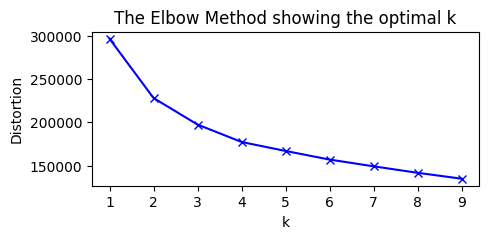

In [109]:
# Search appropriate number of cluster
kmeans_clustering_elbow(df_cluster_pca, k_max=10)

In [110]:
# Obtain kmeans clusters
kmeans, cluster_pred = kmeans_clustering_modelling(df_cluster_pca, k_selected=4)
df.loc[:,'kmeans_cluster'] = cluster_pred
df.groupby(['kmeans_cluster','cat_name'])[['title']].count()

title
kmeans_cluster cat_name                 
0              Deportes y Fitness    417
               Joyas y Relojes       333
               Ropa y Accesorios     638
1              Deportes y Fitness      2
               Joyas y Relojes       153
               Ropa y Accesorios      13
2              Deportes y Fitness    306
               Joyas y Relojes       510
               Ropa y Accesorios     296
3              Deportes y Fitness    256

In [111]:
# Obtain tsne principal components
df_pc_plot = get_tsne_pc(df_cluster_pca=df_cluster_pca, df=df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2924 samples in 0.001s...
[t-SNE] Computed neighbors for 2924 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2924
[t-SNE] Computed conditional probabilities for sample 2000 / 2924
[t-SNE] Computed conditional probabilities for sample 2924 / 2924
[t-SNE] Mean sigma: 2.288511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.865341
[t-SNE] KL divergence after 1000 iterations: 1.257286


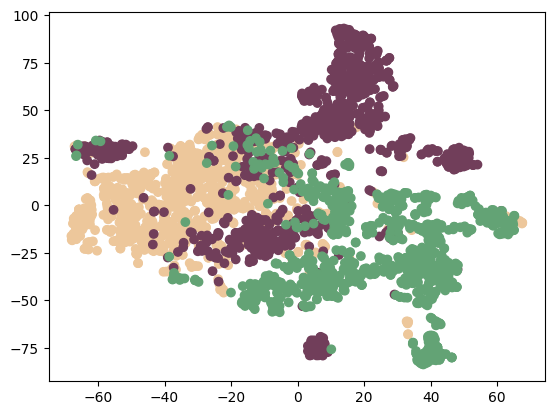

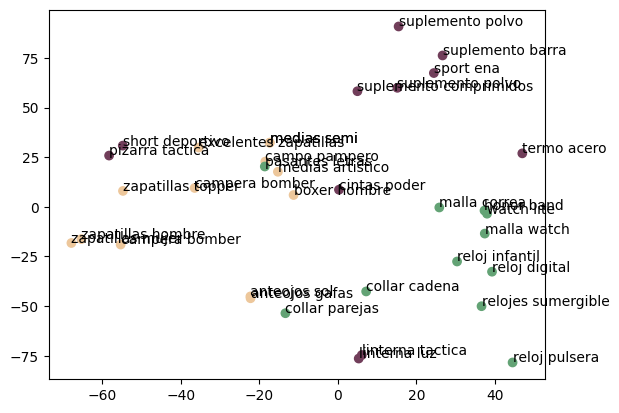

In [112]:
# Plot with categories colors

# Plot cluster x=tsne1 and y=tsne2 (all points)
plot_clusters_vectors(df_pc_plot=df_pc_plot, print_labels='no', colors='cat')

# Plot examples (names are first 2 words in embedding)
plot_clusters_vectors(df_pc_plot=df_pc_plot.iloc[points_examples_plot], 
                      print_labels='yes',
                      colors='cat')

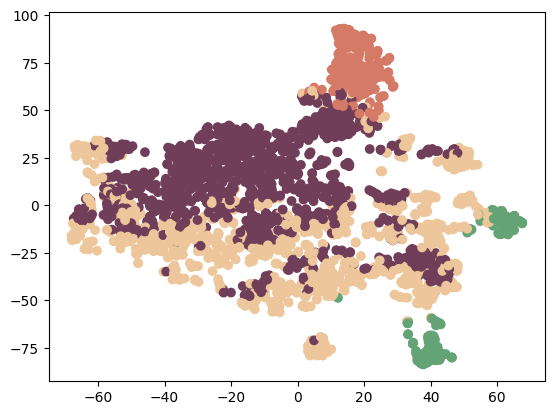

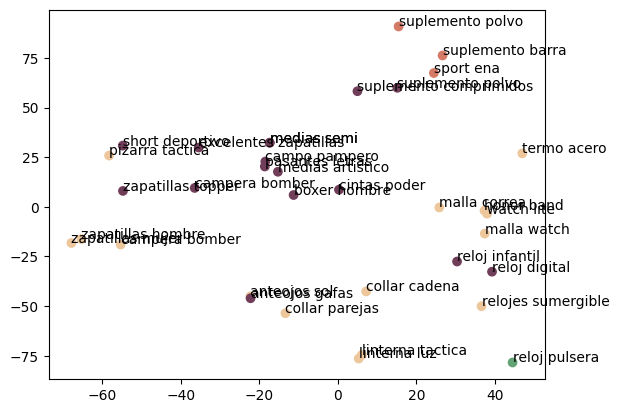

In [113]:
# Plot with kmeans cluster colors

# Plot cluster x=tsne1 and y=tsne2 (all points)
plot_clusters_vectors(df_pc_plot=df_pc_plot, print_labels='no', colors='kmeans')

# Plot examples (names are first 2 words in embedding)
plot_clusters_vectors(df_pc_plot=df_pc_plot.iloc[points_examples_plot], 
                      print_labels='yes',
                      colors='kmeans')